# Similarity, complementarity and structural diversity in interactomes across the tree of life

## Introduction

In [28]:
from typing import Optional, Union, Any, Tuple, Iterable
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.special import logit, expit
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patheffects as PathEffects
import seaborn as sns
import statsmodels.api as sm

# AESTHETICS
COLORS = (
    "#EB7159", 
    "#66C8E6", 
    "#AB65B5", 
    "#829F49",
    "#6876CE",
    "#BE8A3B",
    "#CF5786",
    "#AD483A"
) 
BIODOMAINS = (
    "Archaea", 
    "Bacteria",
    "Eukaryota",
    "Viridiplantae", 
    "Fungi", 
    "Animal"
)
CMAP = dict(zip(BIODOMAINS, COLORS))

sns.set_theme(
    style="ticks",
    font_scale=1.5,
    rc={
        "figure.figsize": (15, 8),
        "font.size": 14,
        "axes.prop_cycle": plt.cycler(color=COLORS),
        "text.latex.preamble": r"\boldmath"
    }
)

HERE = Path(".").absolute()
ROOT = HERE.parent.parent
DATA = HERE/"data"

FIGPATH = ROOT/"figures"/"proteins"
FIGPATH.mkdir(exist_ok=True, parents=True)

FONTS = dict(fontsize=20) 


def diversity_index(
    *data: np.ndarray | pd.Series,
    conditional: bool = False,
    correct: float = 1e-6,
    tol: float = 1e-6
) -> np.ndarray:
    """Calculate diversity index.
    
    Parameters
    ----------
    *data
        Sequence of 1D vectors of probabilities.
        They are horizontally stacked to make a 2D array.
        Then, diversity index for a given row is defined 
        as normalized its Shannon entropy.
    conditional
        If ``False`` then rows in stacked ``*data`` must sum up to ``1``
        to define proper probability distributions.
        If ``True`` then they are expected to sum to something between
        ``0`` and ``1`` and then are normalized.
    """
    probs = np.column_stack([*data])
    assert (probs >= 0-tol).all() & (probs <= 1+tol).all(), \
        "data values must be between 0 and 1"
    
    margin = None
    if conditional:
        assert np.all(probs.sum(axis=1) <= 1+tol), \
            "conditional probabilities cannot sum to more than 1"
        margin = probs.sum(axis=1)    
        margin[margin == 0] = 1
        probs /= margin[:, None]

        tot = probs.sum(axis=1)
        assert np.all(np.isclose(tot, 0) | np.isclose(tot, 1)), \
            "normalized conditional probabilities must sum to 0 or 1"
    else:
        assert np.allclose(probs.sum(axis=1), 1), \
            "probabilities in rows must sum up to 1"
    
    probs = np.clip(probs, 0, 1)
    # Trick for dealing with logs of zeros
    probs[probs == 0] = 1
    entropy  = -(probs * np.log2(probs)).sum(axis=1)
    entropy /= np.log2(probs.shape[1])
    
    if conditional:
        entropy *= margin

    return entropy


## GET AND PREPARE DATA
proteins = joblib.load(DATA/"proteins.pkl.gz")
# Raw coefficients
rdata = proteins["raw"].replace([np.inf, -np.inf], np.nan)
# Calibrated coefficients
cdata = proteins["calibrated"].replace([np.inf, -np.inf], np.nan)
# Null models trends data
tdata = proteins["null_trend"].replace([np.inf, -np.inf], np.nan)
# Fractions of significant nodes
sig01 = proteins["signif_01"].copy()
sig05 = proteins["signif_05"].copy()
sig10 = proteins["signif_10"].copy()
sig   = sig01
# Define additional features
for df in (sig01, sig05, sig10):
    df["neither"] = 1 - df[["sim", "comp", "both"]].sum(axis=1)
    cols = ["sim", "comp", "both", "neither"]
    assert (df["neither"] >= 0).all()
    for col in cols:
        assert df[col].between(0, 1).all()
    assert np.allclose(df[cols].sum(axis=1), 1)

# Add diversity index
for df in (sig01, sig05, sig10):
    df["div"] = diversity_index(
        *df[["sim", "comp", "both"]].values.T,
        conditional=True
    )

In [29]:
# Auxiliary metadata used later for iterating
# over different coefficients used in analyses.
SIM = {
    "sim_g":   r"$s$",
    "sim":     r"$\langle{s_i}\rangle$",
}
COMP = {
    "comp_g":  r"$c$",
    "comp":    r"$\langle{c_i}\rangle$",
}
COEFS = { **SIM, **COMP }

## Raw coefficients

In [30]:
KEYS = [ "biodomain" ]

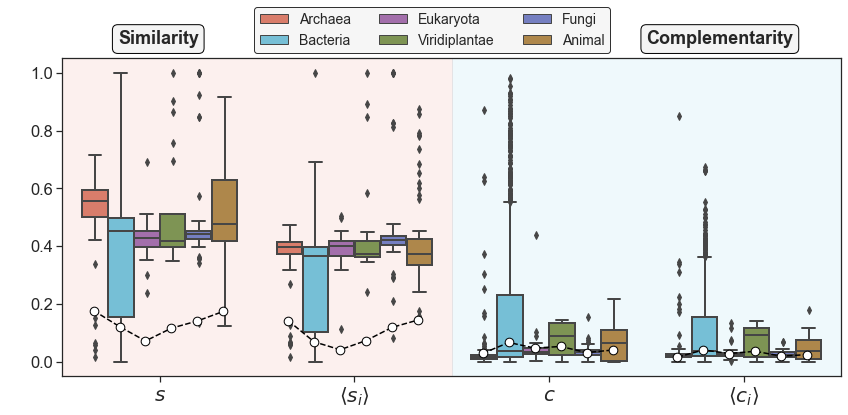

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

data  = rdata.melt(id_vars=KEYS, value_vars=[*COEFS])
    
x = "variable"
y = "value"
hue = KEYS[0]

variables = data[x].unique()
domains   = data[hue].unique()

sns.boxplot(x=x, y=y, hue=hue, data=data, ax=ax, linewidth=2, hue_order=BIODOMAINS)
ax.set_xlabel("")
ax.set_ylabel(" ", **FONTS)
labels = { k: v for k, v in COEFS.items() if k in variables }
ax.set_xticklabels([ labels[c] for c in variables ], **FONTS)
ax.legend(title="")

xlim = ax.get_xlim()
ylim = ax.get_ylim()
kwds = dict(zorder=-99, alpha=.1)
ax.fill_between([-.5, 1.5], -1, 1.2, color=COLORS[0], **kwds) 
ax.fill_between([1.5, 5.5], -1, 1.2, color=COLORS[1], **kwds)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

box  = dict(boxstyle="round", facecolor="#F4F4F4", edgecolor="black")
kwds = dict(fontweight="bold", fontsize=18, bbox=box)
ax.text(.2, 1.1, "Similarity", **kwds, ha="right")
ax.text(2.5, 1.1, "Complementarity", **kwds, ha="left")


# Add null model trends
tdf    = tdata.groupby(KEYS)[[*COEFS]].mean().reset_index()
zod    = 1010
xstart = -.34

for i, col in enumerate([*COEFS]):
    grid = xstart + i + np.arange(6) * .4/3
    yvec = tdf[col]
    ax.scatter(grid, yvec, s=75, color="white", edgecolors="black", zorder=zod+1)
    ax.plot(grid, yvec, ls="--", color="black", zorder=zod)

# Add legend
box  = dict(boxstyle="round", facecolor="white", edgecolor="gray")
kwds = dict(fontweight="bold", fontsize=20, ha="center", bbox=box)

legend = ax.legend(
    ncol=3, frameon=True, 
    edgecolor="black", 
    facecolor="#F4F4F4",
    loc="center",
    bbox_to_anchor=(.475, 1.09),
    fontsize=14
)

fig.tight_layout()

## Interactome size and evolution time

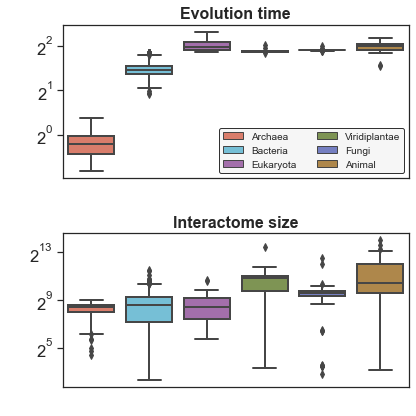

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
data = rdata[[*KEYS, "evo_time", "n_nodes", "dbar", "dcv"]]

x      = KEYS[0]
hue    = x
xticks = dict(
    axis="x",
    which="both",
    bottom=False,
    top=False,
    labelbottom=False
)
box_kws = dict(
    x=x, hue=hue, data=data,
    order=BIODOMAINS,
    hue_order=BIODOMAINS, 
    dodge=False, linewidth=2
)

labels = {
    "evo_time": "Evolution time",
    "n_nodes":  "Interactome size"
}

for kv, ax in zip(labels.items(), axes.flatten()):
    y, title = kv
    sns.boxplot(y=y, ax=ax, **box_kws)

    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")
    ax.get_legend().remove()
    ax.set_yscale("log", base=2)
    ax.tick_params(**xticks)

axes[0].legend(
    ncol=2, fontsize=10, frameon=True, 
    edgecolor="black", facecolor="#F4F4F4"
)

fig.tight_layout()
fig.savefig(FIGPATH/"biodomains-evolution.pdf", bbox_inches="tight")

## Fractions of significant nodes

### Basic Spearman correlations

In [33]:
sig  = sig01
cols = ["n_nodes", "div", "sim", "comp", "both", "neither"]

In [34]:
sig[cols].corr(method="spearman").loc["n_nodes"].to_frame()

,n_nodes
n_nodes,1.000000
div,0.618489
sim,0.522113
comp,-0.292651
both,0.754103
neither,-0.828484


In [35]:
corr = sig.groupby("biodomain")[cols] \
    .corr(method="spearman") \
    .xs("n_nodes", level=-1)

corr

,n_nodes,div,sim,comp,both,neither
biodomain,,,,,,
Animal,1.0,0.605675,0.378094,0.747866,0.493408,-0.666958
Archaea,1.0,0.173062,0.353167,-0.020796,0.176941,-0.442755
Bacteria,1.0,0.591614,0.584748,-0.367043,0.741384,-0.840685
Eukaryota,1.0,0.482557,0.239564,-0.233633,0.599274,-0.603549
Fungi,1.0,0.702168,0.079164,0.419108,0.710893,-0.615571
Viridiplantae,1.0,0.734721,-0.402079,0.756356,0.846555,-0.593050


In [36]:
## PLOT OF GENERAL STRUCTURAL CHARACTERISTICS

def plot_structural_boxplots(
    sig: pd.DataFrame,
    ax: mpl.axes.Axes,
    *,
    legend: bool = False
) -> None:
    """Plot boxplots of proportions of nodes with
    significantly high structural coefficients.

    Parameters
    ----------
    sig
        Data frame with the proportions.
    ax
        Axes to plot on.
    legend
        Should legend be added.
    """
    data = sig.melt(
        value_vars=["sim", "comp", "both"],
        id_vars=["biodomain"]
    )

    kwds = dict(
        x="variable",
        y="value",
        hue="biodomain",
        hue_order=BIODOMAINS,
        linewidth=2
    )

    sns.boxplot(**kwds, data=data, ax=ax)

    kwds = dict(zorder=-99, alpha=.2)

    ax.fill_between([-.5, .5], -.05, 1.05, color=COLORS[0], **kwds) 
    ax.fill_between([.5, 1.5], -.05, 1.05, color=COLORS[1], **kwds)
    ax.fill_between([1.5, 2.5], -.05, 1.05, color=COLORS[2], **kwds)
    ax.set_xlim(-.5, 2.5)
    ax.set_ylim(-.05, 1.05)
    ax.set_title(
        "Fractions of nodes with significantly high values",
        fontsize=32, fontweight="bold"
    )

    ax.set_xlabel("")
    ax.set_ylabel(" ", **FONTS)
    ax.get_legend().remove()
    ax.set_xticklabels(["Sim.", "Comp.", "Both"], **FONTS, fontweight="bold")
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0, decimals=0))

    if legend:
        ax.legend(
            ncol=2, fontsize=20, frameon=True, 
            edgecolor="black", facecolor="#F4F4F4"
        )


def plot_structural_correlations(
    sig: pd.DataFrame,
    ax: mpl.axes.Axes,
    *,
    names: Iterable[str] = ("div", "sim", "comp", "both"),
    labels: Iterable[str] = ("Diversity", "Sim.", "Comp.", "Both")
) -> None:
    """Plot Spearman correlation matrix between proportions
    of nodes with significantly high values of structural
    coefficients and interactome size.

    Parameters
    ----------
    sig
        Data frame with the proportions.
    ax
        Axes to plot on.
    """
    corr = sig.groupby("biodomain")[["n_nodes", *names]] \
        .corr(method="spearman") \
        .xs("n_nodes", level=-1)
    
    data = corr.loc[:, list(names)].T[[*BIODOMAINS]]
    cols = data.columns
    rows = list(labels)

    fonts = dict(fontsize=24, fontweight="bold")

    pvals = []
    coefs = []

    for name in names:
        for col in cols:
            df   = sig[sig["biodomain"] == col]
            r, p = spearmanr(df["n_nodes"], df[name])
            pvals.append(p)
            coefs.append(r)
    
    pvals = multipletests(pvals, method="holm")[1]

    for x in np.arange(len(rows)):
        for y in np.arange(len(cols)):
            p = pvals[x*len(cols) + y]
            r = coefs[x*len(cols) + y]

            if p <= .001:
                star = "***"
            elif p <= .01:
                star = "**"
            elif p < .05:
                star = "*"
            else:
                star = ""
                # Mask non-significant values
                data.values[x, y] = 0

            text = f"{r:.2f}{star}"
            elem = ax.text(y, x, text, ha="center", va="center", size=24, fontweight="bold")
            elem.set_path_effects([
                PathEffects.withStroke(linewidth=5, foreground="white")
        ])
    
    ax.imshow(
        data.values, cmap="coolwarm", vmin=-1, vmax=1,
        aspect=.6
    )
    ax.set_xticklabels([ "", *cols ], **fonts, rotation=45, ha="right")
    ax.set_yticklabels([ "", rows[0], "", rows[1], "", rows[2], "", rows[3] ], **fonts)
    ax.set_xticks(np.arange(len(cols)) + .5, minor=True)
    ax.set_yticks(np.arange(len(rows)) + .5, minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=5)
    ax.tick_params(axis="x", bottom=False)

    ax.set_title(
        r"Spearman $\rho$ correlations with interactome size", 
        fontsize=32, fontweight="bold", y=1.02
    )

/tmp/ipykernel_56584/3529076088.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ "", *cols ], **fonts, rotation=45, ha="right")
/tmp/ipykernel_56584/3529076088.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([ "", rows[0], "", rows[1], "", rows[2], "", rows[3] ], **fonts)


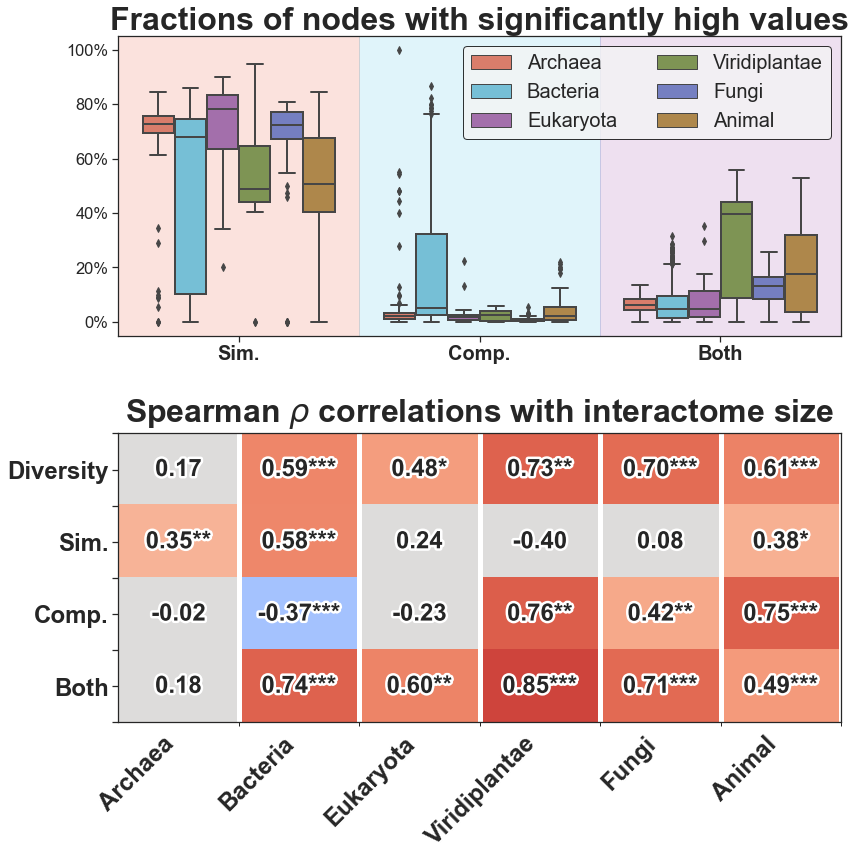

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

ax = axes[0]
plot_structural_boxplots(sig, ax, legend=True)

ax = axes[1]
plot_structural_correlations(sig, ax)

fig.tight_layout(h_pad=3)
fig.savefig(FIGPATH/"biodomains-differences.pdf", bbox_inches="tight")

### Structural diversity and interactome size

In [38]:
def fit_lm(
    y: np.ndarray | pd.Series,
    x: np.ndarray | pd.Series,
    *,
    cov_type: Optional[Union[str, np.ndarray]] = "HC3",
    **kwds: Any
) -> Tuple[Any, Any, pd.DataFrame]:
    """Fit bivariate linear model and produce predictions
    over the observed range of ``x``.

    Parameters
    ----------
    x
        Predictor array (1D).
        Constant is added automatically.
    y
        Outcome array (1D).
    cov
        Optional name of a robust covariance estimator
        or a 1D array with groups for using clustered standard errors.
    
    Returns
    -------
    lm, res, cov, pred
        Fitted model, results, covariance arguments
        and prediction data frame.
    """
    y = np.array(y).astype(float)
    x = np.array(x).astype(float)
    y[np.isinf(y)] = np.nan
    x[np.isinf(x)] = np.nan

    xmask = np.isnan(x)
    if xmask.ndim == 2:
        xmask = xmask.any(axis=1)

    mask = ~xmask & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    X = np.column_stack([np.ones(len(x)), x])

    kwds = { 
        "missing": "drop", 
        **kwds
    }
    cov_kwds = None
    if cov_type is not None and not isinstance(cov_type, str):
        groups = pd.factorize(cov_type)[0]
        groups = groups[mask]
        cov_type = "cluster"
        cov_kwds = dict(groups=groups)

    lm  = sm.OLS(y, X, hasconst=True, **kwds)
    res = lm.fit(cov_type=cov_type, cov_kwds=cov_kwds)

    return lm, res

def get_predictions(
    lm: sm.regression.linear_model.OLS,
    *,
    ci: float = .95, 
    grid_length: int = 1000,
) -> pd.DataFrame:
    """Get prediction data frame from a fitted univariate linear model.
    
    Parameters
    ----------
    lm
        Fitted OLS model.
    ci
        Confidence interval width for plotting trend.
    """
    x    = lm.data.exog[:, -1]
    grid = np.linspace(x.min(), x.max(), grid_length)
    grid = np.column_stack([ np.ones_like(grid), grid  ])
    pred = res.get_prediction(grid).summary_frame(1-ci) \
        .set_index(pd.Series(grid[:, 1], name="predictor"))
    return pred

def format_pval(pv: float, *, threshold: float = .001) -> str:
    """Format pvalue."""
    if pv < threshold:
        s = f"p < {threshold}"
    else:
        s = f"p = {pv:.3f}"
    return s

def plot_lm(
    data: pd.DataFrame,
    pred: pd.DataFrame,
    ax: mpl.axes.Axes
) -> None:
    """Plot linera model.
    
    Parameters
    ----------
    data
        Data frame used to fit the model.
    pred
        Prediction data frame.
    """
    gdf = data.groupby("biodomain")
    kws = dict(s=150, edgecolors="white")

    for dom, col in CMAP.items():
        df = gdf.get_group(dom)

        ax.scatter(df[x], df[y], color=col, **kws)
        grid = np.exp(pred.index.values)
    # Add regression line
    pdf = expit(pred)
    ax.plot(grid, pdf["mean"], color="black", linewidth=4, zorder=10)
    ax.fill_between(grid, pdf["mean_ci_lower"], pdf["mean_ci_upper"], color="black", alpha=.2)

    ax.set_xscale("log")
    ax.set_xlabel("Interactome size", **FONTS, fontweight="bold")
    ax.set_ylabel(
        r"$\mathcal{S}_\alpha(G)$", 
        **FONTS, fontweight="bold"
    )

    # Annotate model fit
    rsq = res.rsquared
    fpv = format_pval(res.f_pvalue)
    box = dict(boxstyle="round", facecolor="white", edgecolor="gray")

    ax.annotate(
        fr"$R^2 = {rsq:.2f}$"+"\n"+rf"${fpv}$",
        (20, .8), fontsize=18, bbox=box
    )
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.tick_params(axis="both", which="minor", labelsize=12)

In [39]:
x = "n_nodes"
y = "div"

data = sig01.copy()
data = data[data[y].between(0, 1, inclusive="neither")]

lm, res = fit_lm(logit(data[y]), np.log(data[x]), cov_type=data["biodomain"])
pred    = get_predictions(lm)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     1040.
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           5.38e-07
Time:                        22:44:14   Log-Likelihood:                -1860.0
No. Observations:                1721   AIC:                             3724.
Df Residuals:                    1719   BIC:                             3735.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5621      0.075    -47.476      0.000      -3.709      -3.415
x1             0.4809      0.015     32.256      0.000       0.452       0.510
==============================================================================
Omnibus:                       46.481   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.126
Skew:                          -0.296   Prob(JB):                     1.96e-14
Kurtosis:                       3.728   Cond. No.                         38.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

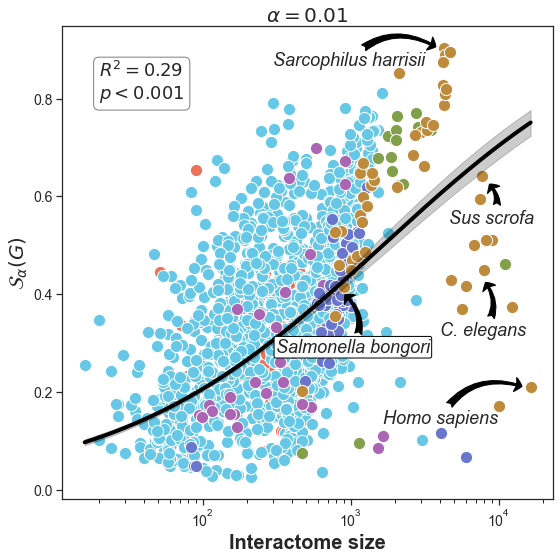

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))

plot_lm(data, pred, ax=ax)
ax.text(
    .5, 1.01, r"$\alpha = 0.01$",
    ha="center", **FONTS, fontweight="bold",
    transform=ax.transAxes
)

# Annotate examples
cols = ["n_nodes", "div"]
kwds  = dict(xycoords="data", fontweight="roman", fontstyle="italic", fontsize=18)
aprop = dict(arrowstyle="fancy,head_width=0.8", color="black")
# Homo sapiens
name   = "Homo sapiens"
xx, yy = data.loc[data["name"] == name, cols].T.iloc[:, 0]
ax.annotate(
    name, xy=(.9*xx, yy), xytext=(.1*xx, .65*yy),
    arrowprops={ **aprop, "connectionstyle": "arc3,rad=-.4" },
    **kwds
)
# Sarcophilus harrisii
name = "Sarcophilus harrisii"
xx, yy = data.loc[data["name"] == name, cols].T.iloc[:, 0]
ax.annotate(
    name, xy=(.9*xx, yy), xytext=(.07*xx, .96*yy),
    arrowprops={ **aprop, "connectionstyle": "arc3,rad=-.4" },
    **kwds
)
# Caenorhabditis elegans
name = "Caenorhabditis elegans"
xx, yy = data.loc[data["name"] == name, cols].T.iloc[:, 0]
ax.annotate(
    "C. elegans", xy=(xx, .95*yy), xytext=(.5*xx, .7*yy),
    arrowprops={ **aprop, "connectionstyle": "arc3,rad=.4" },
    **kwds
)
# Sus scrofa
name = "Sus scrofa"
xx, yy = data.loc[data["name"] == name, cols].T.iloc[:, 0]
ax.annotate(
    name, xy=(1.1*xx, .98*yy), xytext=(.6*xx, .85*yy),
    arrowprops={ **aprop, "connectionstyle": "arc3,rad=.4" },
    **kwds
)
# Salmonella bongori
name = "Salmonella bongori"
xx, yy = data.loc[data["name"] == name, cols].T.iloc[:, 0]
ax.annotate(
    name, xy=(xx, yy), xytext=(.35*xx, .7*yy),
    arrowprops={ **aprop, "connectionstyle": "arc3,rad=.4" },
    bbox=dict(boxstyle="Round", fc="white", ec="black", pad=.1),
    zorder=999,
    **kwds
)

fig.tight_layout()
fig.savefig(FIGPATH/"biodomains-diversity.pdf", bbox_inches="tight")

# SI: Structural diversity analysis

Here we analyze sensitivity of the main results to different choices
of the significance level. In the main paper $\alpha = 0.01$ is used
and here we show results for $\alpha = 0.01, 0.05, 0.10$.

We also discuss some additional details regarding the linear model.

## Boxplots and correlation matrices

### $\alpha = 0.01$

/tmp/ipykernel_56584/3529076088.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ "", *cols ], **fonts, rotation=45, ha="right")
/tmp/ipykernel_56584/3529076088.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([ "", rows[0], "", rows[1], "", rows[2], "", rows[3] ], **fonts)


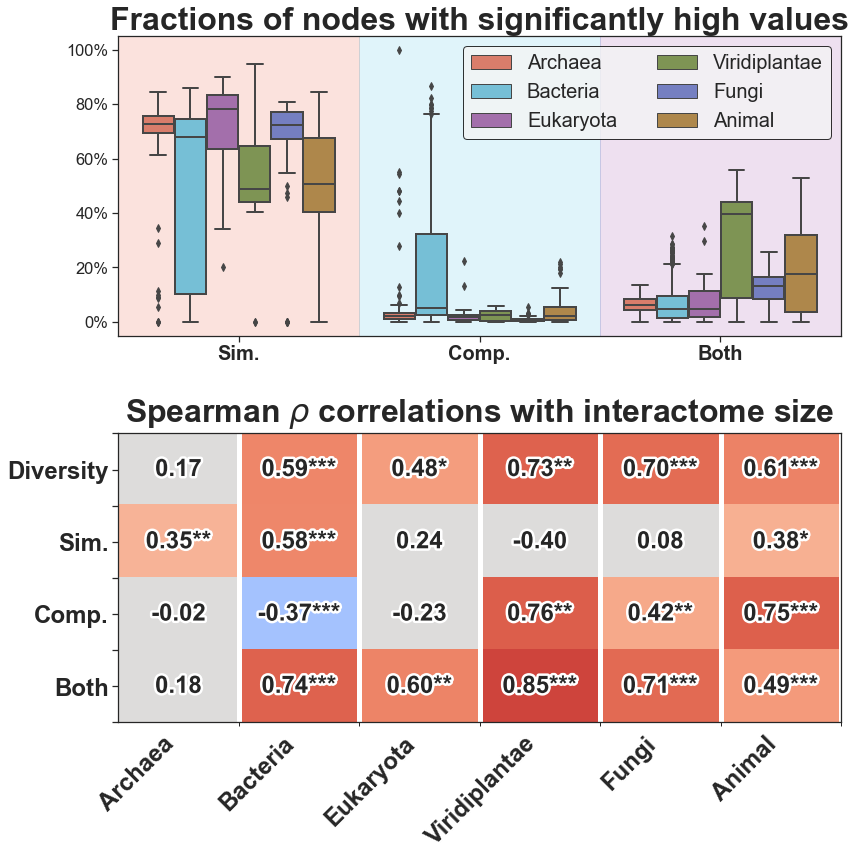

In [41]:
sig = sig01.copy()

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

ax = axes[0]
plot_structural_boxplots(sig, ax, legend=True)

ax = axes[1]
plot_structural_correlations(sig, ax)

fig.tight_layout(h_pad=3)
fig.savefig(FIGPATH/"SI-differences-01.pdf", bbox_inches="tight")

### $\alpha = 0.05$

/tmp/ipykernel_56584/3529076088.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ "", *cols ], **fonts, rotation=45, ha="right")
/tmp/ipykernel_56584/3529076088.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([ "", rows[0], "", rows[1], "", rows[2], "", rows[3] ], **fonts)


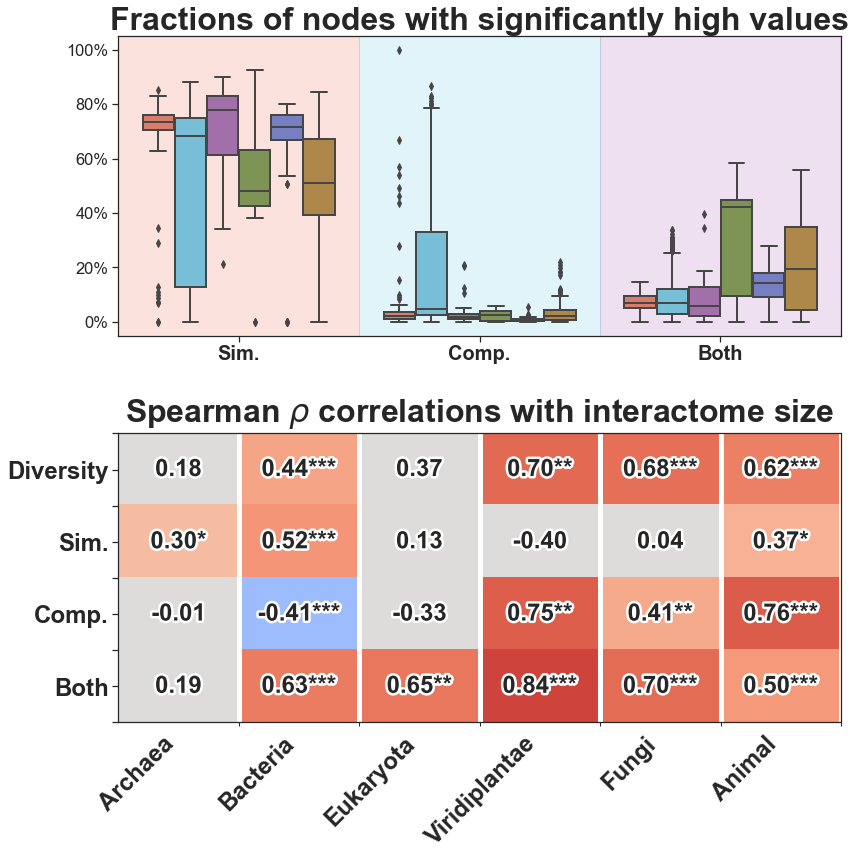

In [42]:
sig = sig05.copy()

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

ax = axes[0]
plot_structural_boxplots(sig, ax, legend=False)

ax = axes[1]
plot_structural_correlations(sig, ax)

fig.tight_layout(h_pad=3)
fig.savefig(FIGPATH/"SI-differences-05.pdf", bbox_inches="tight")

### $\alpha = 0.10$

/tmp/ipykernel_56584/3529076088.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([ "", *cols ], **fonts, rotation=45, ha="right")
/tmp/ipykernel_56584/3529076088.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([ "", rows[0], "", rows[1], "", rows[2], "", rows[3] ], **fonts)


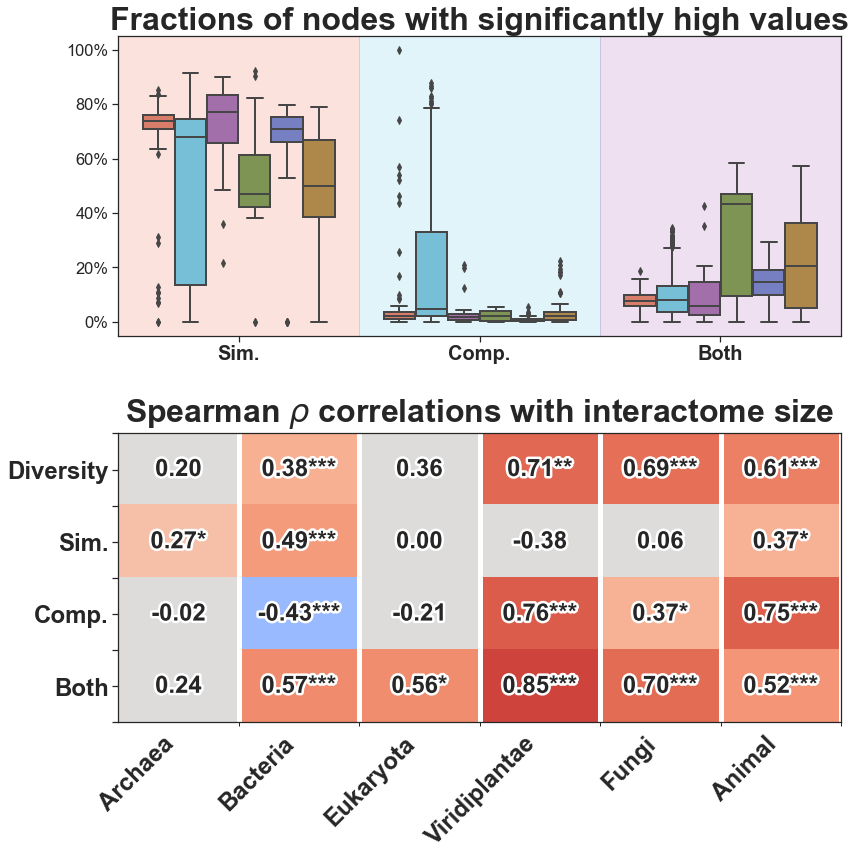

In [43]:
sig = sig10.copy()

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

ax = axes[0]
plot_structural_boxplots(sig, ax, legend=False)

ax = axes[1]
plot_structural_correlations(sig, ax)

fig.tight_layout(h_pad=3)
fig.savefig(FIGPATH/"SI-differences-10.pdf", bbox_inches="tight")

## Linear model

Here we also plot QQ-plots for residuals as well as fitted-residual
scatterplots with LOWESS trends.

In [44]:
from scipy import stats

def plot_qq(res: np.ndarray, ax: mpl.axes.Axes) -> None:
    """Plot QQ plot of Pearson residuals.
    
    Parameters
    ----------
    res
        Vector of Pearson residuals.
    ax
        Axes object to plot on.
    """
    res = np.sort(np.array(res))
    eq  = np.arange(1, len(res)+1) / len(res)
    tq  = stats.norm().ppf(eq)

    ax.scatter(tq, res, color="black", s=100, facecolors="none")
    ax.plot(tq, tq, ls="--", linewidth=3, color="red", zorder=-1)

    ax.set_xlabel("Theoretical quantiles", **FONTS, fontweight="bold")
    ax.set_ylabel("Empirical quantiles", **FONTS, fontweight="bold")
    ax.set_title("QQ-plot (Pearson residuals)", **FONTS, fontweight="bold")

def plot_res(
    res: np.ndarray,
    fit: np.ndarray,
    ax: mpl.axes.Axes,
) -> None:
    """Plot Pearson residuals against fitted values
    and add LOWESS trend.
    
    Parameters
    ----------
    res
        Vector of Pearson residuals.
    fit
        Vector of fitted values.
    ax
        Axes object to plot on.
    """
    df = pd.DataFrame({
        "res": res,
        "fit": fit 
    })
    kwds = dict(x="fit", y="res")

    scatter_kws = dict(s=100, color="black", facecolor="none")
    line_kws    = dict(ls="-", lw=3, color="red")
    sns.regplot(
        data=df, ax=ax, **kwds,
        lowess=True, ci=95,
        scatter_kws=scatter_kws, line_kws=line_kws
    )
    ax.set_xlabel("Fitted values", **FONTS, fontweight="bold")
    ax.set_ylabel("Pearson residuals", **FONTS, fontweight="bold")
    ax.axhline(0, ls="--", color="red", lw=3)
    ax.set_title("Residuals plot", **FONTS, fontweight="bold")

### $\alpha = 0.01$

In [45]:
x = "n_nodes"
y = "div"

data = sig01.copy()
data = data[data[y].between(0, 1, inclusive="neither")]

lm, res = fit_lm(logit(data[y]), np.log(data[x]), cov_type=data["biodomain"])
pred    = get_predictions(lm)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     1040.
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           5.38e-07
Time:                        22:44:45   Log-Likelihood:                -1860.0
No. Observations:                1721   AIC:                             3724.
Df Residuals:                    1719   BIC:                             3735.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5621      0.075    -47.476      0.000      -3.709      -3.415
x1             0.4809      0.015     32.256      0.000       0.452       0.510
==============================================================================
Omnibus:                       46.481   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.126
Skew:                          -0.296   Prob(JB):                     1.96e-14
Kurtosis:                       3.728   Cond. No.                         38.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

#### Adjusted model with publication count

Publication count effect (`x2`) is not significant.

In [46]:
lm, res = fit_lm(logit(data[y]), np.log(data[[x, "pub_count"]]), cov_type=data["biodomain"])
res.summary()

/home/sztal/miniconda3/envs/scs-paper/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     466.4
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           2.08e-06
Time:                        22:44:48   Log-Likelihood:                -1803.4
No. Observations:                1662   AIC:                             3613.
Df Residuals:                    1659   BIC:                             3629.
Df Model:                           2                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5634      0.079    -44.917      0.000      -3.719      -3.408
x1             0.4807      0.017     28.633      0.000       0.448       0.514
x2            -0.0003      0.011     -0.026      0.979      -0.023       0.022
==============================================================================
Omnibus:                       44.925   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.459
Skew:                          -0.293   Prob(JB):                     4.51e-14
Kurtosis:                       3.738   Cond. No.                         46.6
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

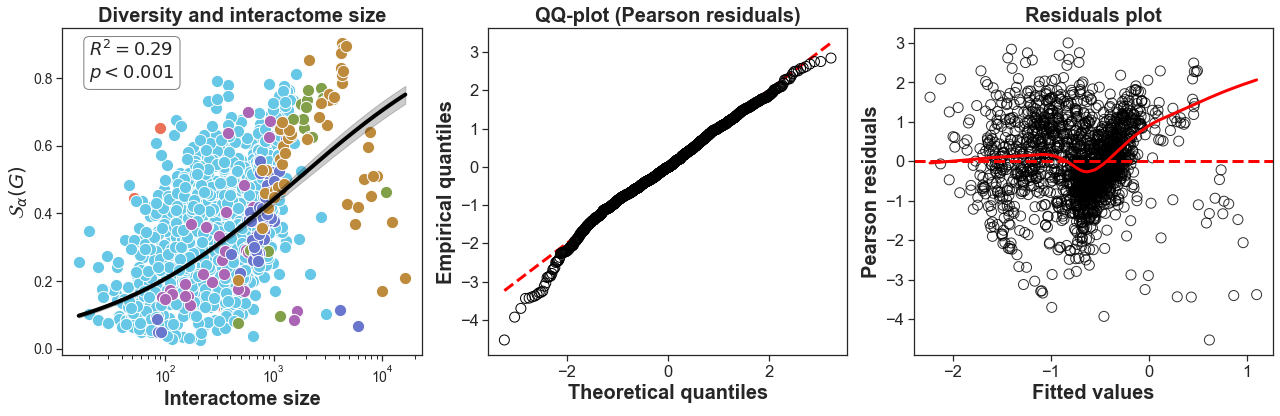

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_lm(data, pred, ax=axes[0])
plot_qq(res.resid_pearson, ax=axes[1])
plot_res(res.resid_pearson, res.fittedvalues, ax=axes[2])

axes[0].set_title("Diversity and interactome size", **FONTS, fontweight="bold")

fig.tight_layout()
fig.savefig(FIGPATH/"SI-model-01.pdf", bbox_inches="tight")

### $\alpha = 0.05$

In [48]:
x = "n_nodes"
y = "div"

data = sig05.copy()
data = data[data[y].between(0, 1, inclusive="neither")]

lm, res = fit_lm(logit(data[y]), np.log(data[x]), cov_type=data["biodomain"])
pred    = get_predictions(lm)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     234.0
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           2.16e-05
Time:                        22:45:00   Log-Likelihood:                -1889.7
No. Observations:                1746   AIC:                             3783.
Df Residuals:                    1744   BIC:                             3794.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5947      0.133    -19.477      0.000      -2.856      -2.334
x1             0.3534      0.023     15.299      0.000       0.308       0.399
==============================================================================
Omnibus:                        6.588   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.538
Skew:                          -0.134   Prob(JB):                       0.0380
Kurtosis:                       3.135   Cond. No.                         37.4
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

#### Adjusted model with publication count

Publication count effect (`x2`) is not significant.

In [49]:
lm, res = fit_lm(logit(data[y]), np.log(data[[x, "pub_count"]]), cov_type=data["biodomain"])
res.summary()

/home/sztal/miniconda3/envs/scs-paper/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     101.0
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           9.07e-05
Time:                        22:45:03   Log-Likelihood:                -1830.7
No. Observations:                1685   AIC:                             3667.
Df Residuals:                    1682   BIC:                             3684.
Df Model:                           2                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5911      0.143    -18.175      0.000      -2.871      -2.312
x1             0.3533      0.026     13.730      0.000       0.303       0.404
x2            -0.0014      0.009     -0.155      0.876      -0.019       0.016
==============================================================================
Omnibus:                        6.128   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.079
Skew:                          -0.129   Prob(JB):                       0.0479
Kurtosis:                       3.141   Cond. No.                         45.2
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

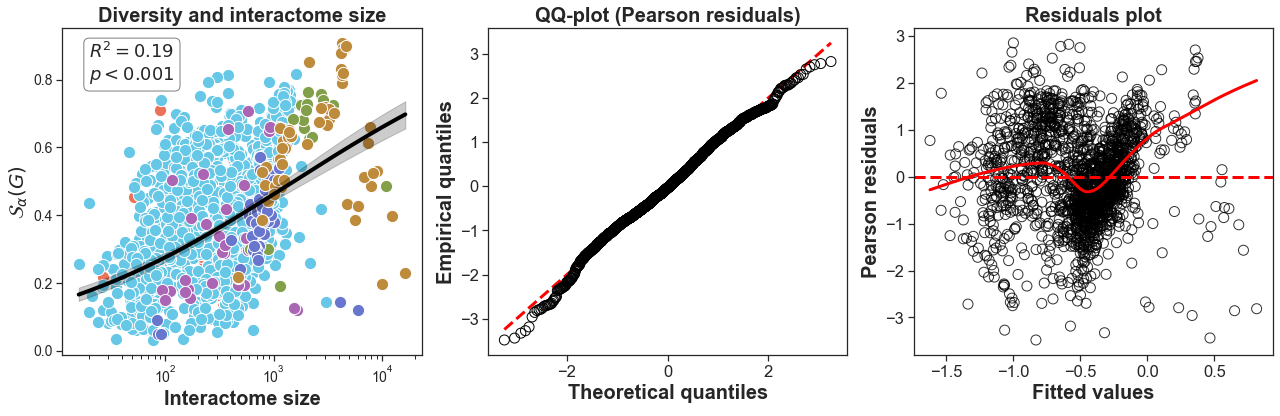

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_lm(data, pred, ax=axes[0])
plot_qq(res.resid_pearson, ax=axes[1])
plot_res(res.resid_pearson, res.fittedvalues, ax=axes[2])

axes[0].set_title("Diversity and interactome size", **FONTS, fontweight="bold")

fig.tight_layout()
fig.savefig(FIGPATH/"SI-model-05.pdf", bbox_inches="tight")

### $\alpha = 0.10$

In [51]:
x = "n_nodes"
y = "div"

data = sig10.copy()
data = data[data[y].between(0, 1, inclusive="neither")]

lm, res = fit_lm(logit(data[y]), np.log(data[x]), cov_type=data["biodomain"])
pred    = get_predictions(lm)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     117.0
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           0.000117
Time:                        22:45:09   Log-Likelihood:                -1867.5
No. Observations:                1752   AIC:                             3739.
Df Residuals:                    1750   BIC:                             3750.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1394      0.164    -13.048      0.000      -2.461      -1.818
x1             0.2922      0.027     10.817      0.000       0.239       0.345
==============================================================================
Omnibus:                        8.451   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.861
Skew:                          -0.129   Prob(JB):                       0.0119
Kurtosis:                       3.234   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

#### Adjusted model with publication count

Publication count effect (`x2`) is not significant.

In [52]:
lm, res = fit_lm(logit(data[y]), np.log(data[[x, "pub_count"]]), cov_type=data["biodomain"])
res.summary()

/home/sztal/miniconda3/envs/scs-paper/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     52.14
Date:                Sat, 05 Mar 2022   Prob (F-statistic):           0.000448
Time:                        22:45:12   Log-Likelihood:                -1808.3
No. Observations:                1691   AIC:                             3623.
Df Residuals:                    1688   BIC:                             3639.
Df Model:                           2                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1289      0.172    -12.369      0.000      -2.466      -1.792
x1             0.2899      0.029      9.971      0.000       0.233       0.347
x2             0.0005      0.009      0.062      0.951      -0.016       0.017
==============================================================================
Omnibus:                        8.535   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                9.030
Skew:                          -0.129   Prob(JB):                       0.0109
Kurtosis:                       3.248   Cond. No.                         44.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

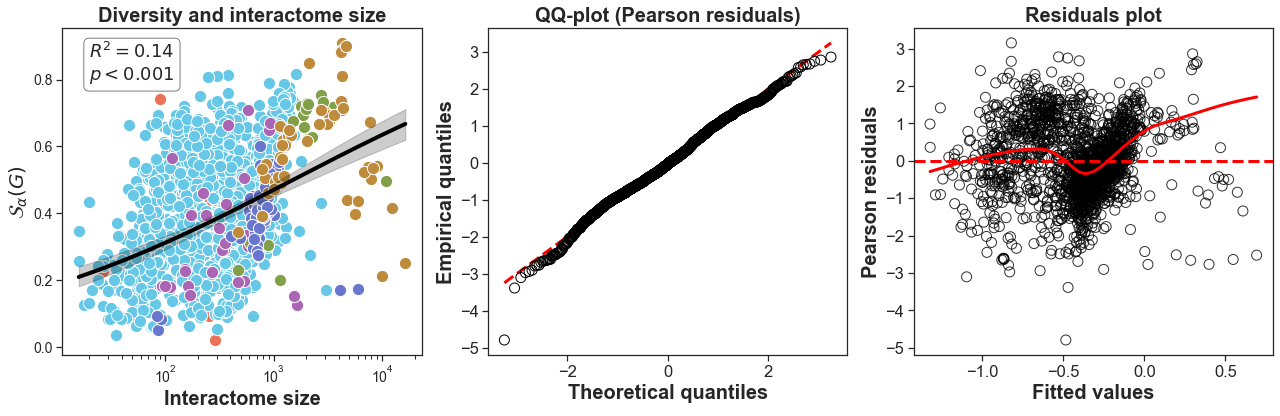

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_lm(data, pred, ax=axes[0])
plot_qq(res.resid_pearson, ax=axes[1])
plot_res(res.resid_pearson, res.fittedvalues, ax=axes[2])

axes[0].set_title("Diversity and interactome size", **FONTS, fontweight="bold")

fig.tight_layout()
fig.savefig(FIGPATH/"SI-model-10.pdf", bbox_inches="tight")